In [1]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

"""
del(x_test, y_test)
x_train = x_train/255

x_test = x_train[40000:50000]
y_test = y_train[40000:50000]

x_train = x_train[0:40000]
y_train = y_train[0:40000]
"""
x_train= x_train/255
x_test = x_test/255

170500096/170498071 [==============================] - 15s 0us/step


In [0]:
# one_hot maker
def one_hot(vector):
    one_hot_vec = np.zeros([len(vector), int(max(vector[0:len(vector)])+1)])
    
    for i in range(len(one_hot_vec)):
        one_hot_vec[i, vector[i, 0]] = 1
       
    return one_hot_vec

In [0]:
# creating minibatches
def mini_batch(X, Y, size):
    idx = np.random.randint(np.size(Y[:, 0]), size = (size,1))
    x_bat = X[idx]
    x_bat = x_bat.reshape(size, 32, 32, 3)
    y_bat = Y[idx]
    y_bat = y_bat.reshape(size, 10)
    
    return x_bat, y_bat

In [0]:
tf.reset_default_graph()
# placeholders
x = tf.placeholder(tf.float32, [None,32,32,3])
y = tf.placeholder(tf.float32,[None, 10])

# weights

w1 = tf.get_variable('w1', [4,4,3,32], initializer=tf.contrib.layers.xavier_initializer())
w2 = tf.get_variable('w2', [4,4,32,64], initializer=tf.contrib.layers.xavier_initializer())
w3 = tf.get_variable('w3', [4,4,64,128], initializer=tf.contrib.layers.xavier_initializer())
w4 = tf.get_variable('w4', [4,4,128,256], initializer=tf.contrib.layers.xavier_initializer())
w5 = tf.get_variable('w5', [4,4,256,512], initializer=tf.contrib.layers.xavier_initializer())

In [48]:
# CNN model
with tf.device("/gpu:0"):
    c1 = tf.nn.relu(tf.nn.conv2d(x, w1, strides = [1,1,1,1], padding = 'SAME'))
    m1 = tf.nn.avg_pool(c1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    c2 = tf.nn.relu(tf.nn.conv2d(m1, w2, strides = [1,1,1,1], padding='SAME'))
    c3 = tf.nn.relu(tf.nn.conv2d(c2, w3, strides = [1,1,1,1], padding='SAME'))
    m2 = tf.nn.avg_pool(c3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    drop_1 = tf.nn.dropout(m2, 0.8)
    
    c4 = tf.nn.relu(tf.nn.conv2d(drop_1, w4, strides = [1,1,1,1], padding='SAME'))
    c5 = tf.nn.relu(tf.nn.conv2d(c4, w5, strides = [1,1,1,1], padding='SAME'))
    drop_2 = tf.nn.dropout(c5, 0.8)
    
    # flattening the previous max pool layer
    flat = tf.contrib.layers.flatten(drop_2)
    
    final = tf.layers.dense(flat, 10)
    
    classifier = tf.nn.softmax(final)
    
    print('model summary')
    print('x     : ', x.shape)
    print('c1    : ', c1.shape)
    print('m1    : ', m1.shape)
    print('c2    : ', c2.shape)
    print('c3    : ', c3.shape)
    print('m2    : ', m2.shape)
    print('c4    : ', c4.shape)
    print('c5    : ', c5.shape)
    print('flat  : ', flat.shape)
    print('final : ', classifier.shape)
    
    
    # optimization
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = final, labels = y))
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

model summary
x     :  (?, 32, 32, 3)
c1    :  (?, 32, 32, 32)
m1    :  (?, 16, 16, 32)
c2    :  (?, 16, 16, 64)
c3    :  (?, 16, 16, 128)
m2    :  (?, 8, 8, 128)
c4    :  (?, 8, 8, 256)
c5    :  (?, 8, 8, 512)
flat  :  (?, 32768)
final :  (?, 10)


In [49]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

cost = []
# training
for epoch in range(1200):
    x_batch, y_batch = mini_batch(x_train, one_hot(y_train), 64)
    training_step = sess.run(optimizer, {x: x_batch, y: y_batch})
    
    if epoch%500==0:
        print("Iteration: ", epoch)
    
    cost.append(sess.run(loss, {x: x_batch, y: y_batch}))

Iteration:  0
Iteration:  500
Iteration:  1000


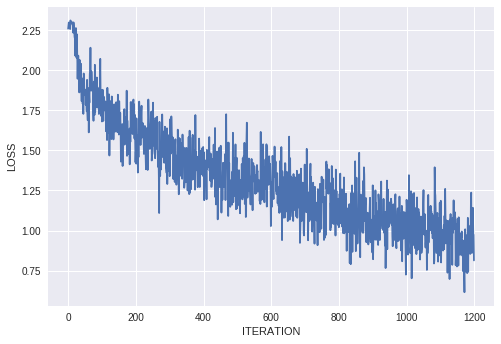

In [50]:
plt.plot(range(0, epoch+1), cost[:])
plt.xlabel("ITERATION")
plt.ylabel("LOSS")
plt.show()

In [51]:
randomness = range(1, 6000)
# test set evaluation
test_loss = sess.run(loss, {x: x_test[randomness], y: one_hot(y_test[randomness])})

print("loss on training set : ", cost[-1])
print("loss on test set     : ", test_loss)

# metrics
test_true= tf.equal(np.argmax(sess.run(classifier, {x: x_test[randomness]}), axis=1), np.argmax(y_test[randomness], axis=1))
test_accuracy = tf.reduce_mean(tf.cast(test_true, dtype="float"))

train_true = tf.equal(np.argmax(sess.run(classifier, {x: x_train[randomness]}), axis=1), np.argmax(y_train[randomness], axis=1))
train_accuracy = tf.reduce_mean(tf.cast(train_true, dtype="float"))

train_score = sess.run(train_accuracy)*100
test_score = sess.run(test_accuracy)*100

print("train accuracy : %.2f" %train_score, "%")
print("test accuracy  : %.2f" %test_score, "%")

loss on training set :  0.8140873
loss on test set     :  1.0838499
train accuracy : 7.20 %
test accuracy  : 7.12 %
